In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

# We will be using the pairs we found to simulate FY24
# Signal rules

entry_z = 1.5
exit_z = 0.5
stop_z = 3.0

In [361]:
rolling_window = 252

tickers = ["JPM", "GS", "PEP", "KO", "V", "MA"]
pairs = [("JPM","GS"), ("PEP","KO"), ("V","MA")]
data = pd.read_csv("data.csv", index_col=0, parse_dates=True)[tickers]
idx = data.iloc[len(data) - rolling_window : len(data)].index
data

,JPM,GS,PEP,KO,V,MA
Date,,,,,,
2022-12-29,124.329124,321.799103,168.066101,59.294582,203.813110,342.593689
2022-12-30,125.150429,321.752289,166.847031,58.979340,203.519272,342.121490
2023-01-03,126.102333,324.413391,165.692612,58.367374,203.156784,341.206451
2023-01-04,127.278244,325.800201,165.286255,58.339558,208.270248,349.421814
2023-01-05,127.250031,322.108307,163.559235,57.671978,206.800858,346.096252
...,...,...,...,...,...,...
2024-12-24,238.440506,577.038086,149.826797,61.939281,319.019257,533.352844
2024-12-26,239.257263,575.493469,149.464020,61.673145,319.277985,533.790955
2024-12-27,237.318726,570.493408,149.905228,61.554871,317.039398,529.858337


In [ ]:
# Setting up the data and scaling using natural log
log_data = np.log(data)

def z_score_calc(pair):
    stock1, stock2 = pair
    rolling_b1 = pd.Series(np.nan, index=log_data.index)
    rolling_b0 = pd.Series(np.nan, index=log_data.index)
    rolling_mean = pd.Series(np.nan, index=log_data.index)
    rolling_std = pd.Series(np.nan, index=log_data.index)

    # Calculating Z_t

    for i in range(rolling_window, len(log_data)):
        past_data = log_data.iloc[i - rolling_window : i]
        past_data = past_data.loc[:, [stock1, stock2]]
        X = past_data[stock1].values
        Y = past_data[stock2].values

        Xm = sm.add_constant(X) # Xm specifcally refers to the variable to be used in the model
        model = sm.OLS(Y, Xm).fit()

        b_0, b_1 = model.params

        residuals = Y - (b_0 + b_1 * X) 
        mean = residuals.mean()
        std = residuals.std()

        rolling_b0.iloc[i] = b_0
        rolling_b1.iloc[i] = b_1
        rolling_mean.iloc[i] = mean
        rolling_std.iloc[i] = std

    rolling_spread = log_data[stock2] - (rolling_b0 + rolling_b1 * log_data[stock1]) 

    z_score = (rolling_spread - rolling_mean)/rolling_std

    z_score = z_score.dropna()

    # Dropping values with NaN values (Specifically the ones for the year 2023)

    return z_score

JPM_GS_z = z_score_calc(pairs[0])
PEP_KO_z = z_score_calc(pairs[1])
V_MA_z = z_score_calc(pairs[2])

In [363]:
# We now want to calculate the stationary spread serise of 2023 to calculate the pair's half-life
def static_spread(pair, log_data,
                train_start="2023-01-01",
                  train_end="2023-12-31"):
    A, B = pair
    train = log_data.loc[train_start:train_end, [A, B]].dropna()
    X = sm.add_constant(train[A].values)
    Y = train[B].values
    model = sm.OLS(Y, X).fit()
    b0, b1 = model.params
    spread = train[B] - (b0 + b1*train[A])

    return spread, b1
    # We will be using b1 to calculate the weight of our stock pairings later


In [364]:
# Our function for stop time for each pair
def stop_time_calc(pair, log_data):
    x, _ = static_spread(pair, log_data, train_start="2023-01-01", train_end="2023-12-31")
    phi = (x.shift(1) * x).sum() / (x.shift(1)**2).sum()
    if 0 < phi < 1:
        halflife = -np.log(2) / np.log(phi)
    else:
        halflife = 60  # fallback
    stop_time = int(np.clip(np.ceil(2.0 * halflife), 20, 90))
    return stop_time


In [ ]:
# Position Loop (long, short, flat)
# s will represent the position state (0 = flat, +1 = long, -1 = short)

def state_age(z_score, pair, log_data):
    stop_time = stop_time_calc(pair, log_data)
    state = pd.Series(0, index=idx)
    age   = pd.Series(0, index=idx)

    for i in range (1, len(z_score)):
        z = z_score.iloc[i]
        prev = state.iloc[i-1]
        s = prev
        if prev == 0:
            if z >= entry_z:
                s = +1
            elif z <= -entry_z:
                s = -1
            else:
                s = 0
        else:
            if abs(z) <= exit_z:
                s = 0
            if age.iloc[i-1] >= stop_time:
                s = 0
            if abs(z) >= stop_z:
                s = 0
        if s != 0:
            age.iloc[i] = age.iloc[i-1] + 1
        else:
            age.iloc[i] = 0
        state.iloc[i] = s
    return state, age, stop_time

JPM_GS_state, JPM_GS_age = state_age(JPM_GS_z, pairs[0], log_data)
PEP_KO_state, PEP_KO_age = state_age(PEP_KO_z, pairs[1], log_data)
V_MA_state, V_MA_age = state_age(V_MA_z, pairs[2], log_data)

In [ ]:
# Now time to realise the PnL of this strategy

# Execution and Costs
BPS = 10        # 10 bps per leg per trade
BORROW = 0.03       # Borrow fee for shorting stock
initial_capital = 100_000
GROSS_PER_PAIR = 10_000

# Going to define a function to calculate wA and wB

def weight_function(pair,log_data):
    _, b1 = static_spread(pair, log_data, train_start="2023-01-01", train_end="2023-12-31")

    wA = 1 / (1 + abs(b1))
    wB = (-b1) / (1 + abs(b1))

    return wA, wB

# Defining test data (2024 dates)
test_data = data.iloc[len(data) - rolling_window: len(data)]

# Function to calculate PnL day to day
def pnl_calc(priceToday, priceYday, posToday, posYday):
    holding_pnl = (priceToday - priceYday) * posYday

    # Trading Costs
    delta_pos = posToday - posYday
    traded_value = abs(delta_pos) * priceToday
    trade_costs = traded_value * (BPS / 1e4)

    # Borrow costs (for short positions)
    if posYday < 0:
        short_value = abs(posYday) * priceYday
        borrow_costs = short_value * (BORROW / 252)
    else:
        borrow_costs = 0
    
    total_costs = trade_costs + borrow_costs
    total_pnl = holding_pnl - trade_costs - borrow_costs

    return holding_pnl, total_costs, total_pnl

In [368]:
def target_pair_shares(pair, pair_state, priceA_t, priceB_t):
    if pair_state == 0:
        return 0.0, 0.0
    wA, wB = weight_function(pair, log_data)
    s = float(pair_state)         # +1 or -1
    shA = (s * wA * GROSS_PER_PAIR) // priceA_t
    shB = (s * wB * GROSS_PER_PAIR) // priceB_t
    return shA, shB

def position_update_pair(state_act_t, state_act_tm1,
                         posA_prev, posB_prev,
                         priceA_t, priceB_t,
                         pair):
    # Only trade when state changes
    if state_act_t == state_act_tm1:
        return posA_prev, posB_prev
    
    return target_pair_shares(pair, state_act_t, priceA_t, priceB_t)

In [ ]:
def portfolio_backtest(data, pairs, state_map):
    """
    data:   wide DataFrame with all tickers
    pairs:  list of tuples, e.g. [("JPM","GS"), ("PEP","KO"), ("V","MA")]
    state_map: dict mapping each pair -> state Series (e.g., {("JPM","GS"): JPM_GS_state, ...})

    No rebalancing: we only change shares when the (lagged) state changes.
    Capital is shared across pairs: equal-gross per active pair each day.
    """

    # Precompute lagged states aligned to idx
    state_act = {p: state_map[p].reindex(idx).shift(1).fillna(0) for p in pairs}

    # Containers per pair
    per_pair = {}
    for a, b in pairs:
        per_pair[(a, b)] = {
            "posA": pd.Series(0.0, index=idx),
            "posB": pd.Series(0.0, index=idx),
            "holdA": pd.Series(0.0, index=idx),
            "holdB": pd.Series(0.0, index=idx),
            "costA": pd.Series(0.0, index=idx),
            "costB": pd.Series(0.0, index=idx),
            "pnlA": pd.Series(0.0, index=idx),
            "pnlB": pd.Series(0.0, index=idx),
            "pair_total": pd.Series(0.0, index=idx),
        }

    # Portfolio series
    port_pnl = pd.Series(0.0, index=idx)
    equity = pd.Series(np.nan, index=idx)
    equity.iloc[0] = initial_capital

    # Main loop
    for i in range(1, len(idx)):
        t = idx[i]
        # Today's prices for all legs
        PA = {p: data[p[0]].loc[t] for p in pairs}
        PB = {p: data[p[1]].loc[t] for p in pairs}
        # Today/yesterday states
        s_t   = {p: state_act[p].iloc[i]   for p in pairs}
        s_tm1 = {p: state_act[p].iloc[i-1] for p in pairs}

        day_pnl = 0.0

        for p in pairs:
            a, b = p
            # Previous positions
            shA_prev = per_pair[p]["posA"].iloc[i-1]
            shB_prev = per_pair[p]["posB"].iloc[i-1]

            # Default: carry positions
            shA_t = shA_prev
            shB_t = shB_prev

            if s_t[p] != s_tm1[p]:
                # State changed → size to new targets with equal gross budget
                wA, wB = weight_function(p, log_data)
                s = float(s_t[p])

                notA = abs(wA) * GROSS_PER_PAIR
                notB = abs(wB) * GROSS_PER_PAIR

                # Floor to integer shares; apply sign via w*s
                shA_t = (notA // PA[p]) * np.sign(wA * s)
                shB_t = (notB // PB[p]) * np.sign(wB * s)

                # If state is flat, force flat
                if s_t[p] == 0:
                    shA_t, shB_t = 0.0, 0.0

            # Per-leg PnL
            hA, cA, pA = pnl_calc(PA[p], data[a].iloc[i-1], shA_t, shA_prev)
            hB, cB, pB = pnl_calc(PB[p], data[b].iloc[i-1], shB_t, shB_prev)

            # Record per pair
            per_pair[p]["posA"].iloc[i] = shA_t
            per_pair[p]["posB"].iloc[i] = shB_t
            per_pair[p]["holdA"].iloc[i] = hA
            per_pair[p]["holdB"].iloc[i] = hB
            per_pair[p]["costA"].iloc[i] = cA
            per_pair[p]["costB"].iloc[i] = cB
            per_pair[p]["pnlA"].iloc[i]  = pA
            per_pair[p]["pnlB"].iloc[i]  = pB
            per_pair[p]["pair_total"].iloc[i] = pA + pB

            day_pnl += (pA + pB)

        # Update portfolio PnL/equity
        E_prev = equity.iloc[i-1]
        port_pnl.iloc[i] = day_pnl
        equity.iloc[i] = E_prev + day_pnl

    # MultiIndex DataFrame
    combined = pd.concat(
        {
            f"{a}-{b}": pd.DataFrame({
                f"{a} position": per_pair[(a,b)]["posA"],
                f"{b} position": per_pair[(a,b)]["posB"],
                f"{a} Holding PnL": per_pair[(a,b)]["holdA"],
                f"{b} Holding PnL": per_pair[(a,b)]["holdB"],
                f"{a} Trading costs": per_pair[(a,b)]["costA"],
                f"{b} Trading costs": per_pair[(a,b)]["costB"],
                f"{a} PnL": per_pair[(a,b)]["pnlA"],
                f"{b} PnL": per_pair[(a,b)]["pnlB"],
                f"{a}-{b} total PnL": per_pair[(a,b)]["pair_total"],
            })
            for (a,b) in pairs
        },
        axis=1
    )

    # Summing up columns except for position columns (our pd.DataFrame is a MultiIndex frame)
    if isinstance(combined.columns, pd.MultiIndex):
        metrics = combined.columns.get_level_values(-1) 
        mask = metrics.str.contains(r"PnL|cost", case=False, regex=True)
    else:
        metrics = combined.columns.astype(str)
        mask = metrics.str.contains(r"PnL|cost", case=False, regex=True)

    totals = combined.loc[:, mask].sum(numeric_only=True)
    total_row = pd.Series(index=combined.columns, dtype=float, name="TOTAL")
    total_row.loc[combined.columns[mask]] = totals.values
    combined = pd.concat([combined, total_row.to_frame().T])
    combined = combined.round(2)

    # Portfolio summary
    portfolio = pd.DataFrame({
        "Portfolio daily PnL": port_pnl,
        "Portfolio equity": equity
    })

    totals_portfolio = pd.Series({
        "Portfolio daily PnL": portfolio["Portfolio daily PnL"].sum(),
        "Portfolio equity": portfolio["Portfolio equity"].iloc[-1]  # final equity
    }, name="TOTAL")
    portfolio = pd.concat([portfolio, totals_portfolio.to_frame().T])
    portfolio = portfolio.round(2)

    return combined, portfolio


In [ ]:
states = {
    pairs[0]: JPM_GS_state,
    pairs[1]: PEP_KO_state,
    pairs[2]: V_MA_state,
}

combined, portfolio = portfolio_backtest(data, pairs, states)

combined.to_csv("combined_summary.csv")
portfolio.to_csv("portfolio_summary.csv")

# Full results breakdown day-to-day available in the summaries

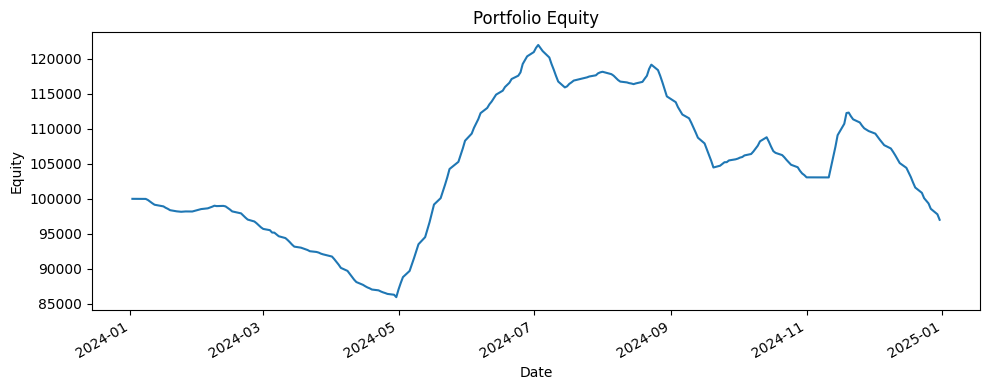

In [ ]:
# Equity curve throughout FY24

port = portfolio.loc[portfolio.index != "TOTAL"].copy()
ax = port["Portfolio equity"].plot(figsize=(10, 4), title="Portfolio Equity")
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
plt.tight_layout()
plt.show()
